In [1]:
import sys
sys.path.append ( '../ ')

In [2]:
"""
Basic I / O routines for the.h5 files
"""
import numpy as np
import pandas as pd
import os
import h5py
import pickle

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

from numpy.random import seed
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences



2023-05-28 15:22:55.793763: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 15:22:55.899526: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 15:22:55.901346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 15:22:56.872648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Visulization

In [3]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import seaborn  as sns
import h5py
from vispy import io
from matplotlib.pyplot import cm
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from cycler import cycler
import os
import subprocess
import glob


In [4]:
def plot_background_image (cs = False, alpha = 0.5):
    """
    Plotting the background image
    """

    background_image = io.image.imread(cs) # ../data/imagge
    fig, ax = plt.subplots()
    ax.imshow(background_image, cmap='gray', alpha = alpha)

def scatter_df (df, x_name = 'x_position', y_name = 'y_position', hue ="class_id", marker = ".", palette = "bright"):
    """ 
    Scattering a data-frame
    """ 
    sns.scatterplot(data = df, x = x_name, y = y_name, hue = hue, marker = marker, palette= palette)

def heat_df (df, x_name = 'x_position', y_name = 'y_position', bins = 50, cmap = "hot"):
    """ 
    Heatmap of a data-frame
    """ 
    sns.histplot(data = df, x = x_name, y = y_name, bins = bins, cbar = True, cmap = cmap)

def plot_trajectories(df, tracknrs = None, track_name = "track_id", class_name = "class_id", x_name = "x_position", y_name = "y_position", annotate=False, end_points=True, all_points =False, color_type ="class", extent=[-35,35,-35,35]):
    """ 
    Trajectories of dataframe 
    """ 
    unique_tracknrs = df[track_name].unique()
    if(tracknrs is None):
        tracknrs = unique_tracknrs 
    fig, ax = plt.subplots()
    for track in tracknrs:
        if (track not in unique_tracknrs):
            continue
        colors =["red", "black", "blue", "yellow"]
        cl = int(df.loc[df[track_name]==track][class_name].iloc[0]%4)

        color = color_type
        if (color_type=="class"):
            color = colors[cl]
        if (color_type is None):
            color=None
        
        ax.plot(df.loc[df[track_name]==track][x_name], df.loc[df[track_name]==track][y_name], linewidth=0.5, color = color)

    #     if(end_points):
    #         matplotlib.axes.Axes.scatter(df.loc[df[track_name]==track][x_name].iloc[0], df.loc[df[track_name] == track][y_name].iloc[0], marker=".", c="red")
    #         matplotlib.axes.Axes.scatter(df.loc[df[track_name]==track][x_name].iloc[1], df.loc[df[track_name] == track][y_name].iloc[1], marker=".", c="blue")

    #     if(annotate):
    #         matplotlib.axes.Axes.text(df.loc[df[track_name]==track][x_name].iloc[0], df.loc[df[track_name] == track][y_name].iloc[0],int(track))
    #         matplotlib.axes.Axes.text(df.loc[df[track_name]==track][x_name].iloc[-1], df.loc[df[track_name] == track][y_name].iloc[-1],int(track))

    #     if(all_points):
    #         scatter_df(df.loc[df[track_name]==track], ax, palette ='bright')
    # matplotlib.axes.Axes.set_xlim(extent[0], extent[1])
    # matplotlib.axes.Axes.set_ylim(extent[2], extent[3])
    if(color_type=="class"):
        blue_patch = mpatches.Patch(color ='red', label = '4| Pedestrian')
        red_patch = mpatches.Patch(color ='black', label = '1| Bicycle')
        green_patch=mpatches.Patch(color = 'blue', label = '18| light vehicle')
        yellow_patch = mpatches.Patch(color='yellow', label = '-1| unknow')
        ax.legend(title='class_id', handles=[red_patch, blue_patch, green_patch, yellow_patch], loc='upper right', bbox_to_anchor=(1,1))



# Get data

In [5]:
def get_data_directory():
    """ 
    Gets the data Directory of the currenty system :return: current data directory

    """
    tmp = os.path.dirname(os.getcwd())
    if os.path.isdir('data'):
        return os.getcwd()
    else:
        return'{}/{}/{}/{}'. format(tmp, 'data', 'Viscando_Koelliken_Trajectory_data', 'Koelliken_offline_tracks_30min')


def get_img_path(cs=False):
    """
    Gets the path of image
    : param cs: True if with coordinate system, Default without
    """
    if (cs == False):
        img_path = 'background_img.png'
    else:
        img_path = 'background_img_cs.png'
    data_path = '{}/{}'. format(get_data_directory(), img_path)
    return data_path


def get_sensor_data_names():
    """
    Returns an list with the data names (- h5 - files)
    """
    return ['data_109.h5', 'data_130.h5', 'data_142.h5', 'data_143.h5']


def get_offline_data_name():
    """
    Returns the name for the OfflineTrack
    """
    return ['Otus3D_koelliken_30min.h5']


def get_offline_data_path():
    """get_offline_data_name()
    Returns the offline data path (concatenated)
    """
    l = ['{}/{}'.format(get_data_directory(), k) for k in get_offline_data_name()]
    return l


def read_offline_data(data_path=get_offline_data_path()[0], type="States", prediction=False):
    """
    Read in offline data
    : param data_path: optional data path
    : type: which key to take, default"States","Detections"to be implemented
    : return: pandas dataframe with offline data
    """
    if (not ((type =="States") | (type =="Detections"))):
        raise"Type needs to be either'Tracks'or'Detections'."
    hf = h5py.File(data_path)
    singlelist_all = ['Track', 'Height_m', 'Length_m', 'Width_m', 'Object_class']
    multlist_all = ['Predictions_time', 'Predictions_x', 'Predictions_y']
    if (prediction == False):
        multlist_all = ['X_local_coordinate_system', 'Y_local_coordinate_system', 'Z_local_coordinate_system', 'Acceleration_ms2', 'Heading_rad', 'Timestamps_UNIX', 'Velocity_ms']
    skiplist_all = ['Attributes']
    singlelist = []
    multlist = []
    skiplist = []
    some_key = list(hf['Tracks'].keys())[0]
    # add keys to single - mult - skiplist that in within h5 - df
    for key in hf["Tracks"][some_key][type]:
        # only add non - empty keys
        if (hf["Tracks"][some_key][type][key].shape[0] == 0):
            continue
        elif (key in singlelist_all):
            singlelist.append(key)
        elif (key in multlist_all):
            multlist.append(key)
        elif (key in skiplist_all):
            skiplist.append(key)
        # else:
        #     print("OBS ! Key { } not added".format(key))
    singlelist.append("Track")
    columns = singlelist + multlist
    # Get data into a numpy array / matrix and then into pandas dataframe
    alldata = np.zeros(shape=(1, len(columns)))
    for track in hf['Tracks'].keys():
        # Number of data points in each track
        if (prediction):
            ndatapoints = len(hf['Tracks'][track][type]['Predictions_x'])
            nattributes = len(columns)
        else:
            ndatapoints = len(hf['Tracks'][track][type]['X_local_coordinate_system'])
            nattributes = len(columns)
        # Initialise tmp
        tmpdata = np.zeros(shape=(ndatapoints, nattributes))
    # Single values
        for i, attribute in enumerate(singlelist):
            if (attribute == 'Track'):
                tmpdata[:, i] = int(track) * np.ones((ndatapoints, 1))[:, 0]
            elif ((attribute == 'Height_m') or (attribute == 'Length_m') or (attribute =='Width_m')):
                tmpdata[:, i] = float(hf['Tracks'][track][type][attribute][:]) * np.ones((
                    ndatapoints, 1))[:, 0]
            else:
                tmpdata[:, i] = int(hf['Tracks'][track][type][attribute][:]) * np.ones((
                    ndatapoints, 1))[:, 0]
        # Multiple values
        for j, attribute in enumerate(multlist):
            tmpdata[:, i + j +
                    1] = np.array(hf['Tracks'][track][type][attribute][:])
        # Stack tmp on all previous data
        alldata = np.vstack([alldata, tmpdata])
    # Put into datframe
    df = pd.DataFrame(alldata[1:, :], columns=columns)
    new_columnname = {'X_local_coordinate_system': 'x_position',
                      'Y_local_coordinate_system': 'y_position',
                      'Z_local_coordinate_system': 'z_position',
                      'Track': 'track_id',
                      'Object_class':"class_id",
                      'Timestamps_UNIX': 'timestamp',
                      'Predictions_x': 'x_position',
                      'Predictions_y': 'y_position',
                      'Predictions_time': 'timestamp',
                      }
    df = df.rename(columns=new_columnname)
    return df


def read_sensor_data(file_name='data_109.h5'):
    """
    Read in sensor data from one file
    : param file_name: file_name within data directory
    : return: pandas dataframe with offline data
    """
    hf = h5py.File('{}/{}'. format(get_data_directory(), file_name), 'r')

    # To iterate over
    timestamps = hf['Timestamp'][:]
    timestamps = np.sort(np.reshape(timestamps, (-1, 1)))
    seq_items = hf['Sequence'].items()

    # Names
    columns = ['index', 'timestamp', 'track_id', 'x_position', 'y_position', 'z_position', 'x_velocity', 'y_velocity', 'z_velocity', 'class_id', 'status']
    # Get data into a numpy array / matrix and then into pandas dataframe
    alldata = np.zeros(shape=(1, len(columns)))
    # For each frame,
    for idx, data in seq_items:
        ntracks_in_current_image = len(data['Tracks'][:])
        # For each track
        tmpdata = np.zeros(shape=(ntracks_in_current_image, 11))
        for i in range(ntracks_in_current_image):

            # index
            tmpdata[i, 0] = int(idx)

            # timestamp
            tmpdata[i, 1] = timestamps[int(idx)]

            # track id
            tmpdata[i, 2] = data['Tracks'][i][0]

            # positions, xyz
            tmpdata[i, 3] = data['Tracks'][i][1][0]
            tmpdata[i, 4] = data['Tracks'][i][1][1]
            tmpdata[i, 5] = data['Tracks'][i][1][2]

            # velocity, xyz
            tmpdata[i, 6] = data['Tracks'][i][2][0]
            tmpdata[i, 7] = data['Tracks'][i][2][1]
            tmpdata[i, 8] = data['Tracks'][i][2][2]

            # class id
            tmpdata[i, 9] = data['Tracks'][i][3]

            # status
            tmpdata[i, 10] = data['Tracks'][i][4]

    # Stack tmp on all previous data
        alldata = np.vstack([alldata, tmpdata])
    # Put into datframe
    df = pd.DataFrame(alldata[1:, :], columns=columns)
    return df


def pickle_df(df, file_name):
    """
    Pickles the datafile to the data directory
    """
    with open(get_data_directory() + '/df_' + file_name + '.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)


def concat_df(dfs, sources):
    """
    Concatenates a list of dataframes, and adds the source .
    : params dfs: list of dataframes
    : sources: list of datasources, in the same order as dataframes
    : return: concatenated dataframe
    """
    for df, source in zip(dfs, sources):
        df["Source"] = source
    df = pd.concat(dfs, axis=0, ignore_index=True)
    return df


def read_full_sensor_data(names=get_sensor_data_names()):
    dfs = []
    sources = []
    for name in names:
        df = read_sensor_data(name)
        dfs.append(df)
        sources.append(name)
    df_full = concat_df(dfs, sources)
    return df_full


def read_pickle_data(file_name, full=False):
    """
    Reads data from pickled file and returns as data frame
    : params file_name: file name
    : full: True if full name is indicated, False if only the name of dataset
    : return: unpickled dataframes
    """
    if (full):
        full_name = get_data_directory() + '/' + file_name
    else:
        full_name = get_data_directory() + '/df_' + file_name + '.pickle'
    with open(full_name, 'rb') as f:
        df = pickle.load(f)
    return df


def sequence_it(hf, return_track=False):
    """Getting a sequence with images and corresponding tracks .
    : param hf: A.h5 sensor file .
    : return_track: boolean, False if does not return track, True o / w
    : return: List of tuples (index, image, tracks) in order .
    """
    # Initialise
    sequence = []
    # To iterate over
    ids = hf['Sequence'].items()
    timestamps_sensor = hf['Timestamp'][:]
    timestamps_sensor = np.sort(np.reshape(timestamps_sensor, (-1, 1)))
    if (return_track):
        wtc = np.array(hf['TMatrixWorldToCam'][:])
        cti = np.array(hf['ProjectionMatrix'][:])
    # For each image,
    for name, value in ids:
        if (return_track == False):
            sequence += [(int(name), value['Image'][:])]
        else:
            ntracks_in_current_image = len(value['Tracks'][:])
        # For each track
            positions = np.zeros(shape=(ntracks_in_current_image, 2))
            for i in range(ntracks_in_current_image):
                pos = plot.world_to_image(np.array(value['Tracks'][i][1].tolist()), wtc, cti)
                positions[i, :] = pos[:]
            sequence += [(int(name), value['Image'][:], positions)]
    # In order
    sequence.sort(key=lambda tup: tup[0])
    return (sequence)

In [6]:
df = read_offline_data(data_path=get_offline_data_path()[0], type="States", prediction=False)


# read_sensor_data(file_name='data_109.h5')
df

,Height_m,Length_m,class_id,Width_m,track_id,Acceleration_ms2,Heading_rad,timestamp,Velocity_ms,x_position,y_position,z_position
0,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,0.000000,-23.055373,-1.587022,-1.032926
1,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,0.000000,-23.030131,-1.701481,-1.054342
2,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,0.000000,-22.988431,-1.812903,-1.104315
3,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,0.000000,-22.945297,-1.932856,-1.056968
4,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,1.531463,-22.911321,-2.051077,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
123855,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,1.574334e+09,6.768232,12.195475,-6.775881,1.000000
123856,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,1.574334e+09,8.094957,12.308388,-8.507507,1.000000
123857,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,1.574334e+09,8.435593,12.460485,-9.320528,1.000000
123858,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,1.574334e+09,8.362752,12.432770,-9.961214,1.000000


# Data Prepocessing 

In [7]:
df_ped_vehicle = df[(df['class_id'] == 4) | (df['class_id'] == 18)]
df_ped_vehicle

,Height_m,Length_m,class_id,Width_m,track_id,Acceleration_ms2,Heading_rad,timestamp,Velocity_ms,x_position,y_position,z_position
0,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,0.000000,-23.055373,-1.587022,-1.032926
1,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,0.000000,-23.030131,-1.701481,-1.054342
2,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,0.000000,-22.988431,-1.812903,-1.104315
3,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,0.000000,-22.945297,-1.932856,-1.056968
4,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,1.574333e+09,1.531463,-22.911321,-2.051077,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
123855,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,1.574334e+09,6.768232,12.195475,-6.775881,1.000000
123856,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,1.574334e+09,8.094957,12.308388,-8.507507,1.000000
123857,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,1.574334e+09,8.435593,12.460485,-9.320528,1.000000
123858,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,1.574334e+09,8.362752,12.432770,-9.961214,1.000000


In [8]:
df_pos_ped_vehicle = df_ped_vehicle[['track_id', 'timestamp','x_position','y_position']]
df_pos_ped_vehicle

,track_id,timestamp,x_position,y_position
0,0.0,1.574333e+09,-23.055373,-1.587022
1,0.0,1.574333e+09,-23.030131,-1.701481
2,0.0,1.574333e+09,-22.988431,-1.812903
3,0.0,1.574333e+09,-22.945297,-1.932856
4,0.0,1.574333e+09,-22.911321,-2.051077
...,...,...,...,...
123855,999.0,1.574334e+09,12.195475,-6.775881
123856,999.0,1.574334e+09,12.308388,-8.507507
123857,999.0,1.574334e+09,12.460485,-9.320528
123858,999.0,1.574334e+09,12.432770,-9.961214


Outliers filtering

In [9]:
def get_tracklength(dfo_track):
    """ 
    Read offline data
    """ 
    dfo_track = dfo_track.sort_values(by=['timestamp'])

    pos = dfo_track[['x_position', 'y_position']]
    n_pos = len(pos.index)
    length = 0
    for i in range(n_pos - 1):
        length += np.sqrt(np.sum((pos.iloc[i].values - pos.iloc[i+1].values) ** 2, axis = 0))
    return (length)

In [10]:
#Filter outliers
def filter_odd(dfo, tracknrs = None, min_nr = 15, min_len = 8, track_name = 'track_id'):
    unique_tracknrs = dfo[track_name].unique()
    if(tracknrs is None):
        tracknrs = unique_tracknrs
    
    dfo.loc['track_len']=0
    for track in tracknrs:
        tmp=len(dfo.loc[dfo[track_name]==track])
        dfo.loc[dfo[track_name]==track, 'track_len'] = tmp

    dfo.loc['bird_dist'] = 0
    for track in tracknrs:
        x1 = dfo.loc[dfo[track_name]==track]['x_position'].iloc[0]
        y1 = dfo.loc[dfo[track_name]==track]['y_position'].iloc[0]
        x2 = dfo.loc[dfo[track_name]==track]['x_position'].iloc[-1]
        y2 = dfo.loc[dfo[track_name]==track]['y_position'].iloc[-1]
        tmp = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        dfo.loc[dfo[track_name] == track, "bird_dist"] = tmp

    dfo_outliers = dfo.loc[(dfo["track_len"] <= min_nr) | (dfo["bird_dist"] <= min_len)]
    dfo_inliers = dfo.loc[(dfo["track_len"] > min_nr) | (dfo["bird_dist"] > min_len)]

    return dfo_outliers, dfo_inliers

In [11]:
#df_descriptors = track_properties(df_ped_vehicle)
dfo2_outliers, dfo2_inliers = filter_odd(df_ped_vehicle, tracknrs = None, min_nr =15, min_len = 15, track_name = 'track_id')

/tmp/ipykernel_3053049/179399351.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo.loc['track_len']=0
/tmp/ipykernel_3053049/179399351.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo.loc[dfo[track_name]==track, 'track_len'] = tmp
/tmp/ipykernel_3053049/179399351.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo.loc['bird_dist'] = 0
/tmp/ipykernel_3053049/179

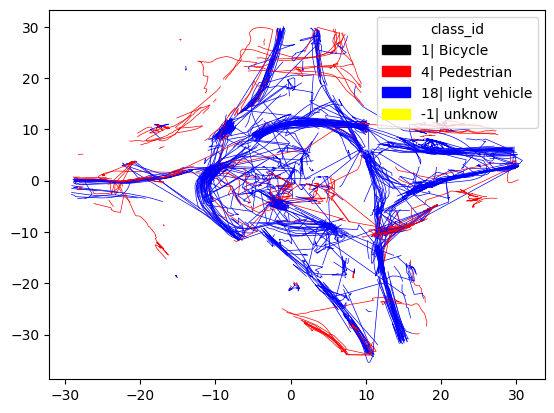

In [12]:
plot_trajectories(dfo2_outliers, tracknrs = None, track_name = "track_id", class_name = "class_id", x_name = "x_position", y_name = "y_position", annotate=False, end_points=True, all_points =False, color_type ="class", extent=[-35,35,-35,35])

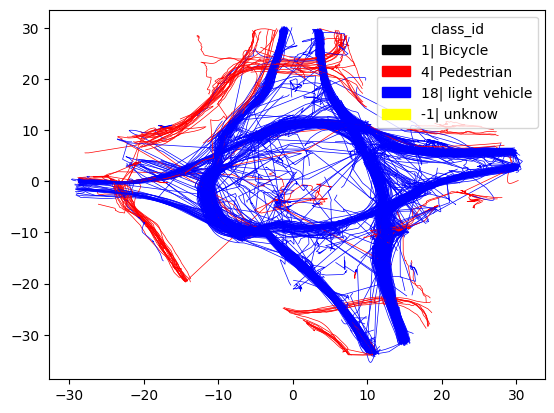

In [13]:
plot_trajectories(dfo2_inliers, tracknrs = None, track_name = "track_id", class_name = "class_id", x_name = "x_position", y_name = "y_position", annotate=False, end_points=True, all_points =False, color_type ="class", extent=[-35,35,-35,35])

Preprocessing data

In [14]:
# Step 1: Data Collection
tracks = df_pos_ped_vehicle['track_id'].unique()

# Step 2 Data Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_data = df_pos_ped_vehicle.copy()
normalized_data[['x_position', 'y_position']] = scaler.fit_transform(normalized_data[['x_position', 'y_position']])
normalized_data['timestamp'] = normalized_data['timestamp'] - 1574333100


In [15]:
for tid, nb in normalized_data['track_id'].value_counts().items():
    # print('trac id :' + str(tid) + ' nbr:' + str(nb))
    if nb < 50 or nb > 300:
        normalized_data = normalized_data.drop(normalized_data[normalized_data.track_id == tid].index)
normalized_data


,track_id,timestamp,x_position,y_position
0,0.0,0.041,-0.779936,0.029849
1,0.0,0.121,-0.779102,0.026366
2,0.0,0.201,-0.777725,0.022976
3,0.0,0.281,-0.776299,0.019326
4,0.0,0.361,-0.775177,0.015729
...,...,...,...,...
123855,999.0,920.361,0.384786,-0.128034
123856,999.0,920.521,0.388517,-0.180723
123857,999.0,920.601,0.393542,-0.205461
123858,999.0,920.681,0.392627,-0.224955


In [16]:
# Step 3: Sequence Creation
sequence_length = 40  # Number of time steps to look back
sequences = []
next_steps = []
for track in tracks:
    track_data = normalized_data[normalized_data['track_id'] == track]
    if len(track_data) >= sequence_length + 10: 
        for i in range(len(track_data) - sequence_length - 10 + 1):
            sequences.append(track_data[['x_position', 'y_position']].iloc[i:i+sequence_length].values)
            next_steps.append(track_data[['x_position', 'y_position']].iloc[i+sequence_length:i+sequence_length+10].values)

In [17]:
# Step 4: Splitting into Training and Testing Sets
sequences = np.array(sequences)
next_steps = np.array(next_steps)
X_train, X_test, y_train, y_test = train_test_split(sequences, next_steps, test_size=0.2, shuffle=True)

In [18]:
# Reshape the target data to match the model's output shape
y_train_reshaped = np.reshape(y_train, (y_train.shape[0], -1))
y_test_reshaped = np.reshape(y_test, (y_test.shape[0], -1))

In [19]:
# Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(40, 2)))  # 64 is the number of LSTM units
model.add(Dense(20))  # Output layer with 2 units for x and y coordinates

2023-05-28 15:23:46.159917: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-28 15:23:46.160010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 7e40382b4c4f
2023-05-28 15:23:46.160030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 7e40382b4c4f
2023-05-28 15:23:46.160420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-05-28 15:23:46.160464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-05-28 15:23:46.160479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2
2023-05-28 15:23:46.486713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor star

In [20]:
# Compile the model
model.compile(loss='mse', optimizer='adam')  # Use mean squared error loss and Adam optimizer

# Train the model
history =  model.fit(X_train, y_train_reshaped, epochs=50, batch_size=32,validation_split=0.2).history  # Adjust the batch size and number of epochs as needed


Epoch 1/50


2023-05-28 15:23:46.995657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 15:23:46.997253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 15:23:46.998155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

640/642 [============================>.] - ETA: 0s - loss: 0.0099

2023-05-28 15:24:03.963428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 15:24:03.965455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 15:24:03.966533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

642/642 [==============================] - 19s 26ms/step - loss: 0.0099 - val_loss: 0.0029
Epoch 2/50
642/642 [==============================] - 17s 26ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 3/50
642/642 [==============================] - 18s 27ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/50
642/642 [==============================] - 16s 24ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/50
642/642 [==============================] - 17s 27ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/50
642/642 [==============================] - 17s 26ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/50
642/642 [==============================] - 16s 25ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/50
642/642 [==============================] - 17s 27ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/50
642/642 [==============================] - 17s 26ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/50
642/642 [==============================] - 19s 29ms/step - loss: 0.0014 - val_los

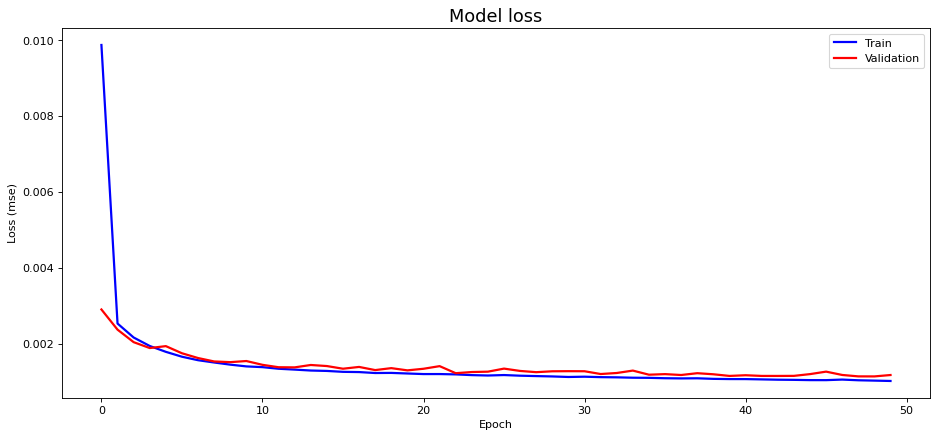

In [21]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [22]:
# Evaluate the model
loss = model.evaluate(X_test, y_test_reshaped)
print("Test loss:", loss)

# Make predictions
predictions = model.predict(X_test)
predictions = np.reshape(predictions, (predictions.shape[0], 10, 2))

201/201 [==============================] - 2s 10ms/step - loss: 0.0011
Test loss: 0.0010533889289945364
  1/201 [..............................] - ETA: 1:26

2023-05-28 15:42:14.536278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 15:42:14.537875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 15:42:14.538758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

201/201 [==============================] - 3s 12ms/step


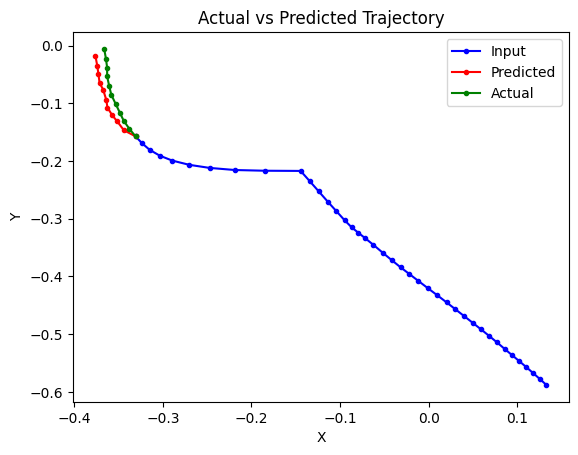

In [27]:
import matplotlib.pyplot as plt

# Select a random sample from the test data
sample_index = 20  # Change this to visualize different samples
sample_X = X_test[sample_index]
sample_y_true = y_test[sample_index]
sample_y_pred = predictions[sample_index]

# Extract x and y coordinates for visualization
x_true = sample_X[:, 0]
y_true = sample_X[:, 1]

x_pred = np.concatenate((sample_X[-1:, 0], sample_y_pred[:, 0]))
y_pred = np.concatenate((sample_X[-1:, 1], sample_y_pred[:, 1]))

x_actual = np.concatenate((sample_X[-1:, 0], sample_y_true[:, 0]))
y_actual = np.concatenate((sample_X[-1:, 1], sample_y_true[:, 1]))

# Plot the Input trajectory
plt.plot(x_true, y_true, 'b.-', label='Input')

# Plot the predicted trajectory
plt.plot(x_pred, y_pred, 'r.-', label='Predicted')

# Plot the actual trajectory
plt.plot(x_actual, y_actual, 'g.-', label='Actual')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Actual vs Predicted Trajectory')
plt.legend()
plt.show()